# Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.

# 0. Importing Libaries

In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import datetime

In [59]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [60]:
device = torch.device('cuda:0')
device 

device(type='cuda', index=0)

# 1. Importing and Preparing Dataset

### Downloading nltk dataset

In [61]:
import nltk
nltk.download('reuters')
nltk.download('punkt')
nltk.download('abc')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package abc to
[nltk_data]     C:\Users\Jue\AppData\Roaming\nltk_data...
[nltk_data]   Package abc is already up-to-date!


True

### Import Australian Broadcasting Corporation (ABC) news for training

In [62]:
from nltk.corpus import abc

In [63]:
# .sents() returns sentences already tokenized
corpus = abc.sents()
len(corpus)

29059

In [64]:
corpus = corpus[0:5000]

In [65]:
len(corpus)

5000

# 2. Preparing training data

In [66]:
corpus = [[word.lower() for word in sent] for sent in corpus]

In [67]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [68]:
word2index = {w: i for i, w in enumerate(vocab)}

In [69]:
voc_size = len(vocab)
print(voc_size)

9774


In [70]:
vocab.append('<UNK>')

In [71]:
word2index['<UNK>'] = voc_size # since current word2index[0:voc_size-1]

In [72]:
index2word = {v:k for k, v in word2index.items()} 

In [73]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9775


In [74]:
for c in corpus:
    print(c)

['pm', 'denies', 'knowledge', 'of', 'awb', 'kickbacks', 'the', 'prime', 'minister', 'has', 'denied', 'he', 'knew', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'iraq', 'wheat', 'sales', '.']
['letters', 'from', 'john', 'howard', 'and', 'deputy', 'prime', 'minister', 'mark', 'vaile', 'to', 'awb', 'have', 'been', 'released', 'by', 'the', 'cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.']
['in', 'one', 'of', 'the', 'letters', 'mr', 'howard', 'asks', 'awb', 'managing', 'director', 'andrew', 'lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'government', 'on', 'iraq', 'wheat', 'sales', '.']
['the', 'opposition', "'", 's', 'gavan', 'o', "'", 'connor', 'says', 'the', 'letter', 'was', 'sent', 'in', '2002', ',', 'the', 'same', 'time', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'though', 'a', 'jordanian', 'trucking', 'company', '.'

In [75]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [76]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ",  input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[ 365]
 [6353]]
Target:  [[5362]
 [9249]]


In [77]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

In [78]:
Z = 0.001

# 3. Negative Sampling`

In [79]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [80]:
word_count[',']

3678

In [81]:
num_total_words

134349

In [82]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [83]:
Counter(unigram_table)

Counter({'the': 109,
         '.': 82,
         'to': 67,
         ',': 67,
         'of': 55,
         'and': 50,
         'a': 47,
         'in': 46,
         "'": 44,
         'is': 35,
         'for': 31,
         '"': 30,
         's': 29,
         'says': 27,
         'that': 26,
         'it': 25,
         'are': 24,
         'he': 23,
         'has': 23,
         'on': 21,
         'from': 21,
         'be': 21,
         'said': 21,
         'have': 21,
         ',"': 20,
         'we': 20,
         '-': 19,
         'will': 19,
         'australia': 18,
         'with': 17,
         'at': 17,
         'but': 15,
         'they': 15,
         'not': 14,
         'been': 14,
         'new': 14,
         'there': 14,
         'as': 13,
         'by': 13,
         'this': 13,
         'farmers': 12,
         'up': 11,
         'industry': 11,
         'growers': 11,
         'more': 11,
         'south': 11,
         'australian': 11,
         'i': 11,
         'which': 10,
      

# 4. Model

In [84]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

In [85]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)
    
    def get_vector(self, word):
        id_tensor = torch.LongTensor([word2index[word]])
        id_tensor = id_tensor
        v_embed = self.embedding_center(id_tensor)  # Corrected
        u_embed = self.embedding_outside(id_tensor)  # Corrected
        word_embed = (v_embed + u_embed) / 2 

        return word_embed

In [86]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [87]:
target_batch.shape

torch.Size([2, 1])

In [88]:
input_batch

tensor([[ 365.],
        [6353.]])

In [89]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[9663, 8690, 6231],
        [5988, 1315, 6202]])

In [90]:
target_batch[1]

tensor([9249])

# 5. Training

In [91]:
batch_size     = 2 # mini-batch size
embedding_size = 50 #  according to word2vec paper 50-300
model          = SkipgramNeg(voc_size, embedding_size)
model = model.to(device) # send model to GPU


optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

In [93]:
import time

# Training
# Since our training data is small, 1000 epochs instead of between 3 and 50 as per the paper
num_epochs = 1000
total_time = 0 # Store total training time
losses = [] # Store losses over training
k = 5 # Negative sample size
start = time.time()
for epoch in range(num_epochs):
    
    
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]
    neg_samples = negative_sampling(target_batch, unigram_table, k)

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    neg_samples = neg_samples.to(device)
    
    optimizer.zero_grad()
    
    loss = model(input_batch, target_batch, neg_samples)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        end = time.time()
        total, epoch_mins, epoch_secs = epoch_time(start, end)
        total_time += total
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()


Epoch: 100 | cost: 7.729578 | time: 0m 24s
Epoch: 200 | cost: 0.008462 | time: 0m 24s
Epoch: 300 | cost: 4.694521 | time: 0m 24s
Epoch: 400 | cost: 8.264224 | time: 0m 24s
Epoch: 500 | cost: 18.532143 | time: 0m 24s
Epoch: 600 | cost: 0.853782 | time: 0m 24s
Epoch: 700 | cost: 11.332625 | time: 0m 24s
Epoch: 800 | cost: 9.005166 | time: 0m 24s
Epoch: 900 | cost: 7.607014 | time: 0m 24s
Epoch: 1000 | cost: 2.070272 | time: 0m 24s


In [94]:
print(f'Training Loss: {loss}, Training Time: {str(datetime.timedelta(seconds=total_time))}')

Training Loss: 2.070272445678711, Training Time: 0:04:03.393545


In [95]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/SkipgramNeg-v1.pt')

In [96]:
Data = {
    'corpus': corpus,
    'vocab': vocab,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': embedding_size
}

In [97]:
pickle.dump(Data,open('./app/models/Data.pkl', 'wb'))

In [98]:
#list of vocabs
vocab[:10]

['john',
 'economist',
 'exercise',
 'fat',
 'operate',
 'corporatisation',
 'hairy',
 'police',
 'mcintosh',
 'intelligence']

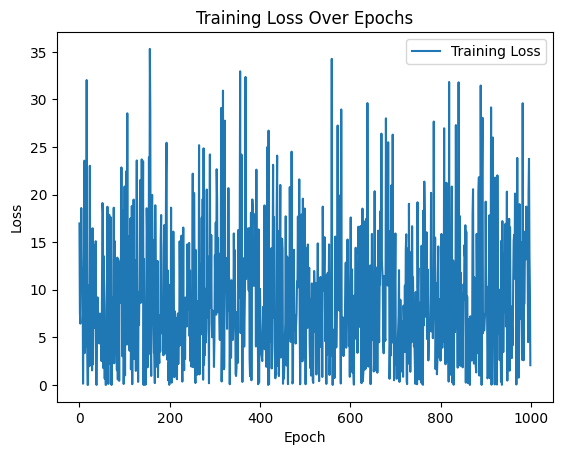

In [99]:
# Extract the numerical values from the tensors
loss_values = [loss.item() for loss in losses]

# Plot the losses
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# 6. Plotting the embeddings

In [100]:
#list of vocabs
vocab[:10]

['john',
 'economist',
 'exercise',
 'fat',
 'operate',
 'corporatisation',
 'hairy',
 'police',
 'mcintosh',
 'intelligence']

In [101]:
word = vocab[0]

In [102]:
#numericalization
id = word2index[word]
id

0

In [103]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [104]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Ensure tensor is on the correct device
id_tensor = id_tensor.to(device)

# Retrieve embeddings
v_embed = model.embedding_center(id_tensor)
u_embed = model.embedding_outside(id_tensor)

print(v_embed, u_embed)


tensor([[ 1.4096, -1.3703,  1.5797,  0.8848,  1.2848, -0.9210, -0.5351, -0.1257,
          0.9455, -0.4244,  0.3554,  1.3530,  0.0043, -0.2230,  0.3729,  1.2637,
         -0.7135, -0.6457, -1.0611,  0.4540, -0.1852, -1.6034, -0.0795, -0.5332,
         -0.6056,  1.2803, -0.0448, -1.1794, -0.0158,  1.5979, -1.6007, -0.6235,
          1.4352, -0.2408,  0.0143, -1.0330, -1.8292,  3.0945,  1.2559, -0.6394,
          0.1061,  0.4471,  0.3267, -0.4754,  0.9362,  0.1538,  0.2662, -0.2699,
          2.1499, -0.5557]], device='cuda:0', grad_fn=<EmbeddingBackward0>) tensor([[ 1.9395e-02,  1.5895e+00,  1.3713e+00,  1.3205e+00, -2.0750e+00,
          6.8072e-01,  2.0957e-01, -3.9440e-01,  7.2534e-01,  3.6865e-01,
         -3.1825e-02, -3.2292e-02, -8.5024e-01, -3.2608e-01, -6.7839e-01,
          4.3879e-02, -3.7441e-01,  1.5614e+00, -5.5078e-01, -1.3398e+00,
         -1.6862e-01, -3.7900e-01, -7.7456e-03,  5.3216e-01, -7.8244e-01,
         -8.1761e-01,  1.2328e-01, -1.2683e-01, -8.7024e-01, -3.5001

In [105]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.1096, device='cuda:0', grad_fn=<SelectBackward0>)

In [106]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)
    # Update attribute names here
    v_embed = model.embedding_center(id_tensor)
    u_embed = model.embedding_outside(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    return word_embed.cpu().detach().numpy()


In [107]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA to reduce embeddings to 2D
pca = PCA(n_components=2)

# Precompute reduced embeddings for the entire vocabulary
def precompute_2d_embeddings(vocab, model):
    embeddings = []
    for word in vocab:
        id_tensor = torch.LongTensor([word2index[word]]).to(device)
        v_embed = model.embedding_center(id_tensor)
        u_embed = model.embedding_outside(id_tensor)
        word_embed = (v_embed + u_embed) / 2
        embeddings.append(word_embed.cpu().detach().numpy())
    embeddings = np.vstack(embeddings)
    return pca.fit_transform(embeddings)

# Reduce the entire vocabulary to 2D once
reduced_embeddings = precompute_2d_embeddings(vocab, model)


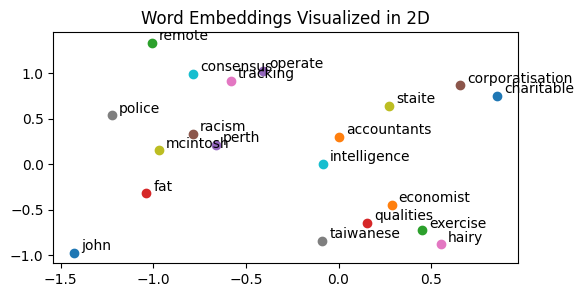

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
for i, word in enumerate(vocab[:20]):  # Loop through the first 20 unique words
    x, y = reduced_embeddings[i]  # Unpack the 2D coordinates
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

plt.title("Word Embeddings Visualized in 2D")
plt.show()


# 7. Cosine similarity

In [109]:
vocab

['john',
 'economist',
 'exercise',
 'fat',
 'operate',
 'corporatisation',
 'hairy',
 'police',
 'mcintosh',
 'intelligence',
 'charitable',
 'accountants',
 'remote',
 'qualities',
 'perth',
 'racism',
 'tracking',
 'taiwanese',
 'staite',
 'consensus',
 'marshes',
 'embraces',
 'james',
 'saves',
 'nq',
 'colin',
 'benefits',
 'shutdown',
 'expenditure',
 'emphasised',
 'hybrid',
 'exports',
 'signals',
 'deliotte',
 'dealt',
 'rowntree',
 'udl',
 ',"',
 'charter',
 'dear',
 'lagoon',
 'enforce',
 'exec',
 'once',
 'mustering',
 '21',
 'skip',
 'written',
 'appointment',
 'although',
 'wildlife',
 'denies',
 'steam',
 'chased',
 'equestrian',
 'retiring',
 'percentage',
 'germinate',
 'cowarie',
 'unexpected',
 'terrain',
 'broadcast',
 'mulloway',
 'indeed',
 'reservoirs',
 'house',
 'quarter',
 'rodert',
 'terramin',
 'ritchie',
 'mysterious',
 'absalom',
 'stalled',
 'breeching',
 'door',
 'indicator',
 'blockages',
 'zoo',
 'demonstrate',
 'but',
 'migrants',
 'removes',
 'court

In [110]:
#let's try similarity between first and second, and second and third
crash         = get_embed('crash')
vines        = get_embed('vines')
rob       = get_embed('rob')

In [111]:
import numpy as np
from numpy.linalg import norm

def cos_sim(a, b):
    # Flatten the vectors to ensure they are 1D
    a = a.flatten()
    b = b.flatten()
    # Compute cosine similarity
    cos_sim = np.dot(a, b) / (norm(a) * norm(b))
    return cos_sim


In [112]:
# Example embeddings
crash = np.random.rand(1, 100)  # Shape (1, 100)
vines = np.random.rand(1, 100)  # Shape (1, 100)
rob = np.random.rand(1, 100)    # Shape (1, 100)

# Compute cosine similarities
print(f"crash vs. vines: {cos_sim(crash, vines)}")
print(f"crash vs. rob: {cos_sim(crash, rob)}")
print(f"crash vs. crash: {cos_sim(crash, crash)}")


crash vs. vines: 0.7947398306294945
crash vs. rob: 0.7052044455283495
crash vs. crash: 0.9999999999999998


In [113]:
from scipy.spatial import distance

def cos_sim(a, b):
    # Ensure the vectors are 1D
    a = a.flatten()
    b = b.flatten()
    # Compute cosine similarity
    cos_sim = 1 - distance.cosine(a, b)  # 1 - distance gives similarity
    return cos_sim


In [114]:
import numpy as np

# Example embeddings
crash = np.random.rand(1, 100)  # Shape (1, 100)
vines = np.random.rand(1, 100)  # Shape (1, 100)
rob = np.random.rand(1, 100)    # Shape (1, 100)

# Compute cosine similarities
print(f"crash vs. vines: {cos_sim(crash, vines)}")
print(f"crash vs. rob: {cos_sim(crash, rob)}")
print(f"crash vs. crash: {cos_sim(crash, crash)}")


crash vs. vines: 0.7789580474942122
crash vs. rob: 0.8074463284678388
crash vs. crash: 1.0
